<a href="https://colab.research.google.com/github/keran-w/Smile_Detection/blob/main/Colabs/ProjML%26AI_Final_Project_RGB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Smile Detection V2

### Setup

In [ ]:
# connect to google drive
from google.colab import drive
from IPython.display import clear_output
drive.mount('/content/drive', force_remount=True)
clear_output()

import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Set a fixed randomness
import os
import torch
import random   
import numpy as np
def seed_everything(seed=20):
    """set seed for all"""
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
SEED = 20
seed_everything(SEED)

In [ ]:
!pip install transformers
clear_output()

In [ ]:
# !pip install torchfile
# !mkdir saved_models
# !wget https://www.robots.ox.ac.uk/~vgg/software/vgg_face/src/vgg_face_torch.tar.gz
# !tar xf vgg_face_torch.tar.gz -C saved_models
# clear_output()

### Data Collection

Data Source:
1. https://www.kaggle.com/datasets/chazzer/smiling-or-not-face-data
2. https://www.kaggle.com/datasets/ghousethanedar/smiledetection
3. https://www.kaggle.com/datasets/shroukmansour/smile-detection-ass


In [ ]:
# import dataset from kaggle
import os
if not os.path.isfile('~/.kaggle/kaggle.json'):
    os.system('mkdir ~/.kaggle')
    os.system('cp /content/drive/MyDrive/kaggle.json ~/.kaggle/kaggle.json')

!kaggle datasets download -d chazzer/smiling-or-not-face-data
!kaggle datasets download -d ghousethanedar/smiledetection
!kaggle datasets download -d shroukmansour/smile-detection-ass
!unzip smiling-or-not-face-data.zip -d .
!unzip smiledetection.zip -d .
!unzip smile-detection-ass.zip -d .
clear_output()
! cp -a ./datasets/test_folder/0/* ./non_smile
! cp -a ./datasets/test_folder/1/* ./smile
! cp -a ./datasets/train_folder/0/* ./non_smile
! cp -a ./datasets/train_folder/1/* ./smile
! cp -a ./'Smile Detection'/negatives_No_Smile/* ./non_smile
! cp -a ./'Smile Detection'/positives_Smile/* ./smile

In [ ]:
# Data preprocessing
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

plt.style.use('seaborn')

non_smile_paths = ['non_smile/' + filename for filename in os.listdir('non_smile')]
smile_paths = ['smile/' + filename for filename in os.listdir('smile')]

images = np.r_[smile_paths, non_smile_paths]
labels = np.r_[np.ones(len(smile_paths)), np.zeros(len(non_smile_paths))].astype('int')
label_map = {0: 'non_smile', 1: 'smile'}
data_df = pd.DataFrame({'image': images, 'label': labels})
# data_df.label.hist()
# plt.show()
data_df

,image,label
0,smile/8333.jpg,1
1,smile/Kyra_Sedgwick_0001.jpg,1
2,smile/file0594.jpg,1
3,smile/1335.jpg,1
4,smile/5262.jpg,1
...,...,...
18363,non_smile/file2907.jpg,0
18364,non_smile/file3678.jpg,0
18365,non_smile/5924.jpg,0
18366,non_smile/Federico_Fellini_0001.jpg,0


Exploratory Data Analysis

In [ ]:
import cv2
from matplotlib import pyplot as plt
import numpy as np
from PIL import Image

def display_batch(images, batch_size=32, transform=None, mode='RGB', seed=20):
    assert mode in ('RGB', 'L')
    np.random.seed(seed)
    sample_idx = np.random.choice(len(images), batch_size)
    rows = len(sample_idx) // 8
    figure, ax = plt.subplots(nrows=rows, ncols=8, figsize=(20, batch_size // rows))

    for i, idx in enumerate(sample_idx):
        image, label = images[idx], labels[idx]
        image = cv2.imread(image)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB 
                             if mode == 'RGB' else cv2.COLOR_BGR2GRAY)
        if transform:
            image = Image.fromarray(transform(image=image)['image'], 
                                    'RGB' if mode == 'RGB' else 'L')
        ax.ravel()[i].imshow(image)
        title = f'{label_map[labels[idx].item()]}({labels[idx]})'
        ax.ravel()[i].set_title(title)
        ax.ravel()[i].set_axis_off()
    plt.tight_layout()
    plt.show()

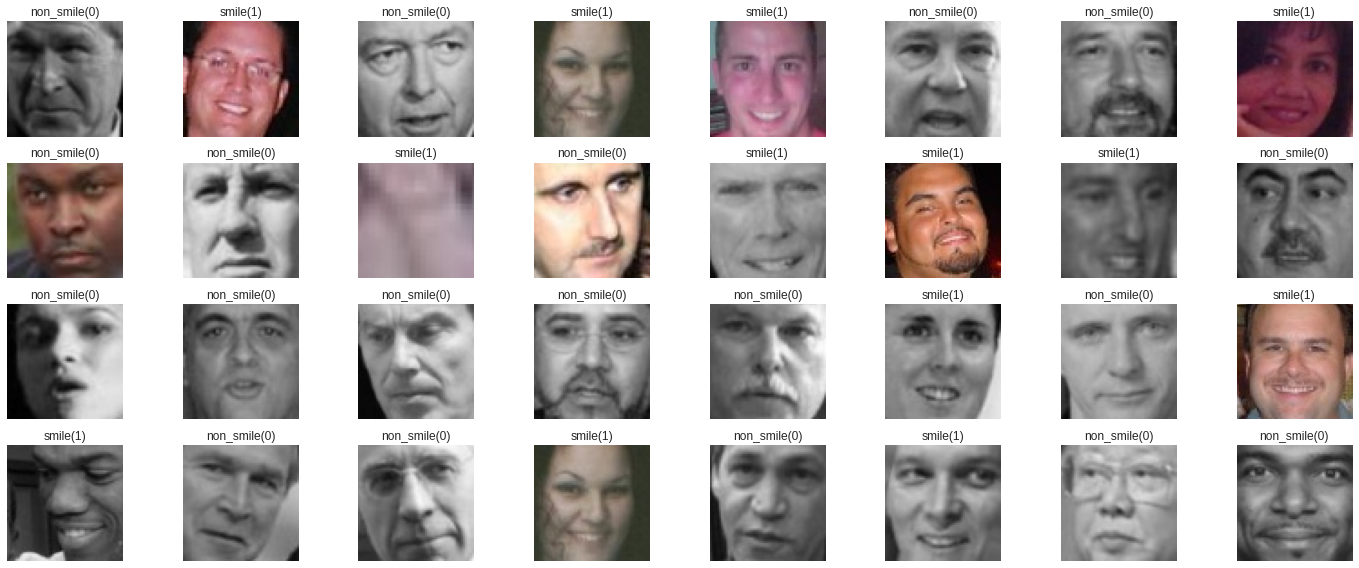

In [ ]:
# Random subset visualization -- RGB
display_batch(images, mode='RGB')

In [ ]:
from PIL import Image

def is_grey_scale(img_path):
    img = Image.open(img_path).convert('RGB')
    w, h = img.size
    for i in range(w):
        for j in range(h):
            r, g, b = img.getpixel((i,j))
            if r != g != b: 
                return False
    return True

# gray_image = [image for image in data_df.image if is_grey_scale(image)]
# rgb_image = [i for i in data_df.image if i not in gray_image]

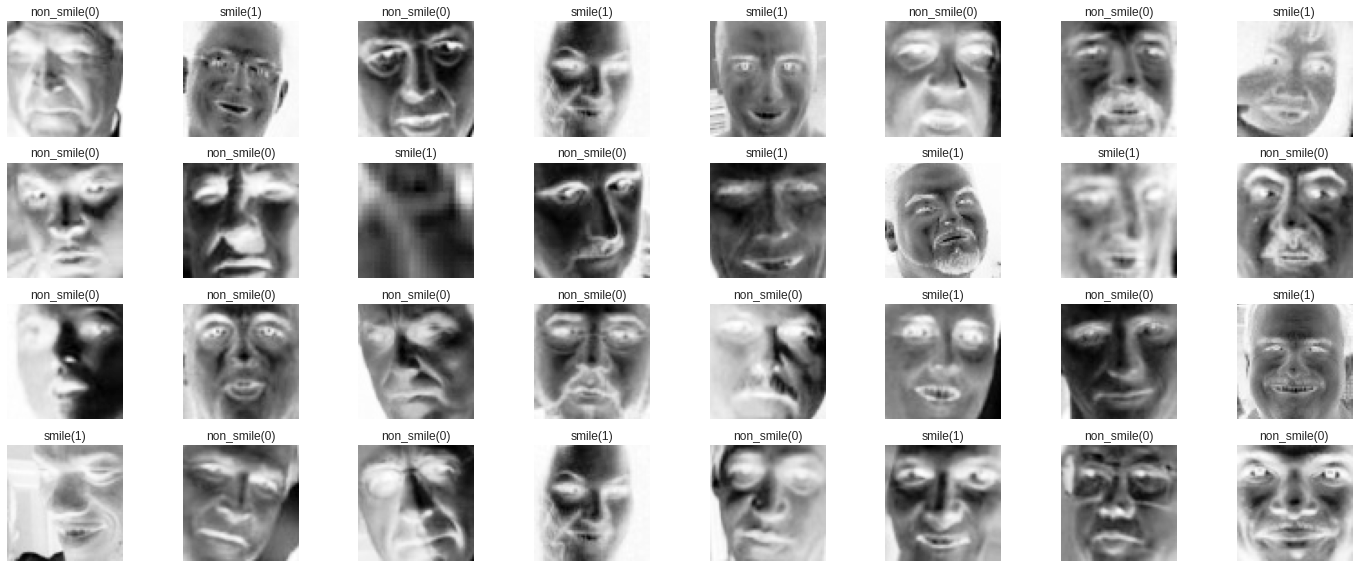

In [ ]:
# Random subset visualization -- Grayscale
display_batch(images, mode='L')

In [ ]:
# Split train and valid set
valid_size = 0.15
valid_idx = np.random.choice(len(images), int(len(images) * valid_size))
train_idx = [idx for idx in range(len(images)) if idx not in valid_idx]
train_images, train_labels, valid_images, valid_labels = \
images[train_idx], labels[train_idx], images[valid_idx], labels[valid_idx]

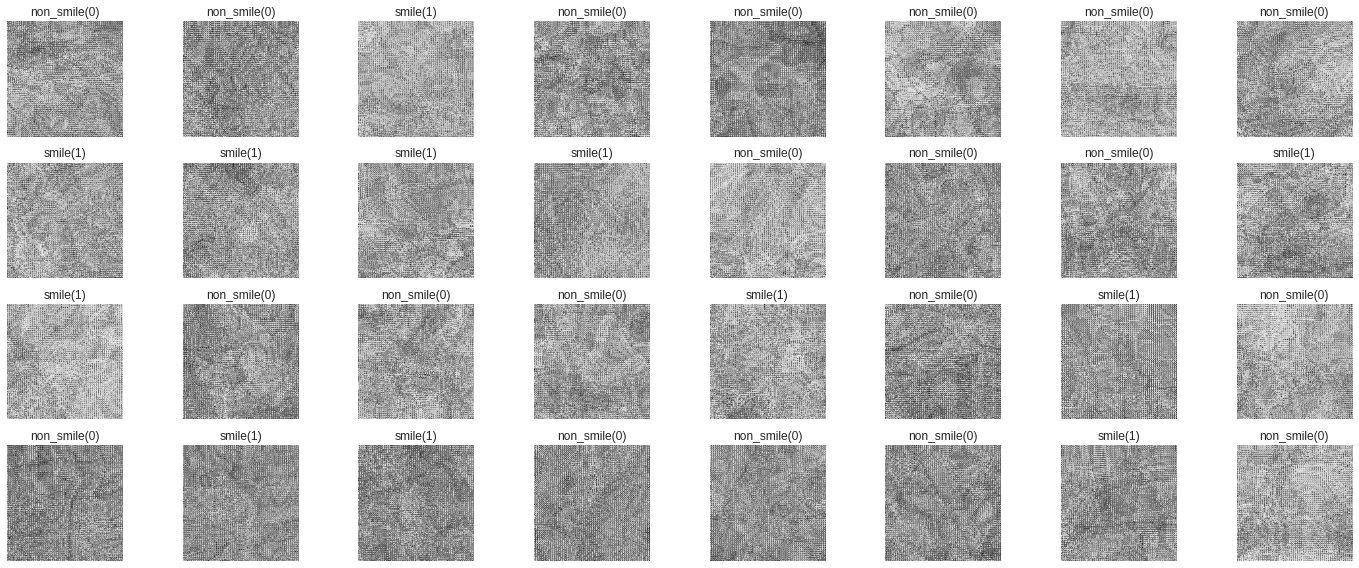

In [ ]:
# Image augmentation
import albumentations as A
from albumentations.pytorch import ToTensorV2
prob = 0.5
train_transform = A.Compose([
    A.Resize(224, 224),
    A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=prob),
    A.VerticalFlip(prob),
    A.Normalize(0.449, 0.226)
])

valid_transform = A.Compose([
    A.Resize(224, 224),
    A.Normalize(0.449, 0.226)
])

# Random subset visualization -- Grayscale with transform
display_batch(train_images, mode='L', transform=train_transform)

In [ ]:
prob = 0.5
train_transform = A.Compose([
    A.Resize(64, 64),
    A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=prob),
    A.VerticalFlip(prob),
    A.Normalize(0.449, 0.226)
])

test_transform = A.Compose([
    A.Resize(64, 64),
    A.Normalize(0.449, 0.226)
])

def get_image(image_pth, transform):
    image = cv2.imread(image_pth)
    # image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    return transform(image=image)['image']

In [ ]:
# Build custom dataset
import cv2

class SmileDataset(torch.utils.data.Dataset):
    
    def __init__(self, images, labels, mode):
        self.labels = labels
        self.images = images
        self.mode = mode
        
    def __len__(self):
        return len(self.images)
         
    def __getitem__(self, index):
        if self.mode == 'train':
            transform = A.Compose([
                A.Resize(64, 64),
                A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=prob),
                A.VerticalFlip(prob),
                A.Normalize(0.449, 0.226)
            ])
        else:
            transform = A.Compose([
                A.Resize(64, 64),
                A.Normalize(0.449, 0.226)
            ])
        

        image = get_image(self.images[index], transform)
        item = {'image': torch.tensor(image), 'mode':self.mode}
        if self.labels is not None:
            item['label'] = self.labels[index]
        return item

def get_loader(images, labels, mode, batch_size, shuffle):
    return torch.utils.data.DataLoader(SmileDataset(images, labels, mode), batch_size=batch_size, shuffle=shuffle)

batch_size = 50
train_loader = get_loader(train_images, train_labels, 'train', batch_size, True)
valid_loader = get_loader(valid_images, valid_labels, 'valid', batch_size, False)

# Get a sample batch
print("Sample train batch")
sample_train_batch = next(iter(train_loader))
print('Attributes:', ', '.join(list(sample_train_batch.keys())))
print('Batch image shape:', sample_train_batch['image'].shape)
print('Batch label shape:', sample_train_batch['label'].shape)

print("\nSample test batch")
sample_test_batch = next(iter(train_loader))
print('Attributes:', ', '.join(list(sample_test_batch.keys())))
print('Batch image shape:', sample_test_batch['image'].shape)
print('Batch label shape:', sample_test_batch['label'].shape)

Sample train batch
Attributes: image, mode, label
Batch image shape: torch.Size([50, 64, 64, 3])
Batch label shape: torch.Size([50])

Sample test batch
Attributes: image, mode, label
Batch image shape: torch.Size([50, 64, 64, 3])
Batch label shape: torch.Size([50])


### Modelling

In [ ]:
import torch.nn as nn
class BasicCNNClassifier(nn.Module):
    def __init__(self, num_classes=2, device='cpu'):
        super(BasicCNNClassifier, self).__init__()
        self.conv1 = nn.Sequential(
            nn.LazyConv2d(
                out_channels=16,
                kernel_size=7,
                stride=1,
                padding=2,
            ),
            nn.GELU(),
            nn.MaxPool2d(kernel_size=2),
        )
        self.conv2 = nn.Sequential(
            nn.LazyConv2d(32, 5, 1, 2),
            nn.GELU(),
            nn.MaxPool2d(kernel_size=2),
        )

        self.out = nn.LazyLinear(num_classes)
        self.device = device
        self.to(device)

    def forward(self, x):
        x = self.conv1(x.to(self.device))
        x = self.conv2(x)
        logits = x
        x = x.view(x.size(0), -1)
        output = self.out(x)
        return output

class VGG16(nn.Module):
    def __init__(self, num_classes=2, device='cpu'):
        super(VGG16, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(16),
            nn.GELU())
        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 16, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(16),
            nn.GELU(), 
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer3 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.GELU())
        self.layer4 = nn.Sequential(
            nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.GELU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer5 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.GELU())
        self.layer6 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.GELU())
        self.layer7 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.GELU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer8 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.GELU())
        self.layer9 = nn.Sequential(
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.GELU())
        self.layer10 = nn.Sequential(
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.GELU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer11 = nn.Sequential(
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.GELU())
        self.layer12 = nn.Sequential(
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.GELU())
        self.layer13 = nn.Sequential(
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.GELU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.fc = nn.Sequential(
            nn.Dropout(0.5),
            nn.LazyLinear(64),
            nn.GELU())
        self.fc1 = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(64, 32),
            nn.GELU())
        self.fc2= nn.Sequential(
            nn.Linear(32, num_classes))
        self.device = device
        self.to(device)
        
    def forward(self, x):
        out = self.layer1(x.to(self.device))
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.layer5(out)
        out = self.layer6(out)
        out = self.layer7(out)
        out = self.layer8(out)
        out = self.layer9(out)
        out = self.layer10(out)
        out = self.layer11(out)
        out = self.layer12(out)
        out = self.layer13(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        out = self.fc1(out)
        out = self.fc2(out)
        return out


class FocalLoss(nn.Module):
    'Focal Loss - https://arxiv.org/abs/1708.02002'

    def __init__(self, gamma=2):
        super(FocalLoss, self).__init__()

        self.gamma = gamma
        self.ce = nn.CrossEntropyLoss()

    def forward(self, input, target):
        logp = self.ce(input, target)
        p = torch.exp(-logp)
        loss = (1 - p) ** self.gamma * logp
        return loss.mean()


sample_basic_model = BasicCNNClassifier(num_classes=2)
print(sample_basic_model(sample_train_batch['image'].view(-1,3,64,64)).shape)

sample_vgg_model = VGG16(num_classes=2)
print(sample_vgg_model(sample_train_batch['image'].view(-1,3,64,64)).shape)

torch.Size([50, 2])
torch.Size([50, 2])


In [ ]:
import torch.optim as optim
from transformers import get_cosine_schedule_with_warmup 

# Define hyperparameters
n_epoch = 10
learning_rate = 1e-4
weight_decay = 1e-3

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
from tqdm.autonotebook import tqdm

# Define train step
def train_step(batch, model, criterion, optimizer, scheduler, device):
    optimizer.zero_grad()
    logits = model(batch['image'].view(-1,3,64,64))
    true_labels = batch['label'].long().to(device)
    loss = criterion(logits, true_labels)
    loss.backward()
    optimizer.step()
    scheduler.step()
    return loss.item()

# Define valid step
def valid_step(batch, model, device):
    logits = model(batch['image'].view(-1,3,64,64))
    true_labels = batch['label'].long().to(device)
    acc = (logits.argmax(1) == true_labels).float().mean().item()
    return acc

# Define runner
def runner(train_loader, valid_loader, n_epoch, model, criterion, optimizer, scheduler, device):
    avg_train_loss_list, avg_valid_acc_list = [], []
    for epoch in range(n_epoch):
        # Initialize epoch metrics
        train_loss_list, valid_acc_list = [], []

        # Training process
        model.train()
        for train_batch in tqdm(train_loader):
            train_loss = train_step(train_batch, model, criterion, optimizer, scheduler, device)
            train_loss_list.append(train_loss)
        avg_train_loss = np.mean(train_loss_list)
        avg_train_loss_list.append(avg_train_loss)

        # Validating process
        model.eval()
        with torch.no_grad():
            for valid_batch in tqdm(valid_loader):
                valid_acc = valid_step(valid_batch, model, device)
                valid_acc_list.append(valid_acc)
        avg_valid_acc = np.mean(valid_acc_list)
        avg_valid_acc_list.append(avg_valid_acc )
        print(f'[ {epoch+1:02d}|{n_epoch} ] avg_train_loss={avg_train_loss:.3f}, valid_acc={avg_valid_acc:.3f}')
    return avg_train_loss_list, avg_valid_acc_list         

In [ ]:
# Initialize model, criterion, optimizer and scheduler
basic_model = BasicCNNClassifier(num_classes=2, device=device)
learning_rate = 2e-6
criterion = FocalLoss(2)
optimizer = optim.Adam(basic_model.parameters(), lr=learning_rate, weight_decay=weight_decay)
scheduler = get_cosine_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=int(len(train_loader)*n_epoch*1.2))
basic_avg_train_loss_list, basic_avg_valid_acc_list = runner(train_loader, valid_loader, n_epoch, basic_model, criterion, optimizer, scheduler, device)

  0%|          | 0/317 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

[ 01|10 ] avg_train_loss=0.165, valid_acc=0.641


  0%|          | 0/317 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

[ 02|10 ] avg_train_loss=0.149, valid_acc=0.641


  0%|          | 0/317 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

[ 03|10 ] avg_train_loss=0.141, valid_acc=0.644


  0%|          | 0/317 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

[ 04|10 ] avg_train_loss=0.134, valid_acc=0.649


  0%|          | 0/317 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

[ 05|10 ] avg_train_loss=0.130, valid_acc=0.651


  0%|          | 0/317 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

[ 06|10 ] avg_train_loss=0.126, valid_acc=0.659


  0%|          | 0/317 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

[ 07|10 ] avg_train_loss=0.123, valid_acc=0.659


  0%|          | 0/317 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

[ 08|10 ] avg_train_loss=0.121, valid_acc=0.661


  0%|          | 0/317 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

[ 09|10 ] avg_train_loss=0.120, valid_acc=0.662


  0%|          | 0/317 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

[ 10|10 ] avg_train_loss=0.120, valid_acc=0.661


In [ ]:
# Initialize model, criterion, optimizer and scheduler
vgg_model = VGG16(num_classes=2, device=device)
criterion = FocalLoss(2)
learning_rate = 2e-6
optimizer = optim.Adam(vgg_model.parameters(), lr=learning_rate, weight_decay=weight_decay)
scheduler = get_cosine_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=int(len(train_loader)*n_epoch*1.2))
vgg_avg_train_loss_list, vgg_avg_valid_acc_list = runner(train_loader, valid_loader, n_epoch, vgg_model, criterion, optimizer, scheduler, device)

  0%|          | 0/317 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

[ 01|10 ] avg_train_loss=0.190, valid_acc=0.368


  0%|          | 0/317 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

[ 02|10 ] avg_train_loss=0.175, valid_acc=0.663


  0%|          | 0/317 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

[ 03|10 ] avg_train_loss=0.163, valid_acc=0.661


  0%|          | 0/317 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

[ 04|10 ] avg_train_loss=0.152, valid_acc=0.662


  0%|          | 0/317 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

[ 05|10 ] avg_train_loss=0.149, valid_acc=0.659


  0%|          | 0/317 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

[ 06|10 ] avg_train_loss=0.144, valid_acc=0.662


  0%|          | 0/317 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

[ 07|10 ] avg_train_loss=0.142, valid_acc=0.662


  0%|          | 0/317 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

[ 08|10 ] avg_train_loss=0.142, valid_acc=0.660


  0%|          | 0/317 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

[ 09|10 ] avg_train_loss=0.140, valid_acc=0.662


  0%|          | 0/317 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

[ 10|10 ] avg_train_loss=0.139, valid_acc=0.662


## Vision Transformer

In [ ]:

# Build model structure
from transformers import get_cosine_schedule_with_warmup
from torch import optim, nn
from torch.nn import functional as F

class ArcFace(nn.Module):
    
    def __init__(self,in_features,out_features, margin = 0.5 ,scale = 20):
        super(ArcFace, self).__init__()

        self.in_features = in_features
        self.out_features = out_features
        self.scale = scale
        self.margin = margin
        self.weights = nn.Parameter(torch.FloatTensor(out_features,in_features))
        nn.init.xavier_normal_(self.weights)
        
    def forward(self,features,targets):
        cos_theta = F.linear(F.normalize(features), F.normalize(self.weights), bias=None) 
        cos_theta = cos_theta.clip(-1, 1)
        
        arc_cos = torch.acos(cos_theta)
        M = F.one_hot(targets, num_classes = self.out_features) * self.margin
        arc_cos = arc_cos + M
        
        cos_theta_2 = torch.cos(arc_cos)
        logits = cos_theta_2 * self.scale
        return logits

class ViTClassifier(torch.nn.Module):
    def __init__(self, vit_model, feature_extractor, num_labels):

        super(ViTClassifier, self).__init__()
        self.vit = vit_model
        self.feature_extractor = feature_extractor
        self.num_labels = num_labels
        self.arcface = ArcFace(768, num_labels, margin=0.3)
    
    def forward(self, batch, device):
        outputs = self.vit(batch['image'].to(device))
        last_hidden_state = outputs.last_hidden_state[:,0,:]
        if batch['mode'] == 'train':
            return self.arcface(last_hidden_state)
        else:
            return F.linear(F.normalize(last_hidden_state), F.normalize(self.arcface.weights))

In [ ]:
# Build custom dataset
import cv2

class SmileDataset(torch.utils.data.Dataset):
    
    def __init__(self, images, labels, mode, feature_extractor, transform=None):
        self.labels = labels
        self.images = images
        self.feature_extractor = feature_extractor
        self.transform = transform
        self.mode = mode
        
    def __len__(self):
        return len(self.images)
         
    def __getitem__(self, index):
        # image = Image.open(self.images[index])
        image = cv2.imread(self.images[index])
        if self.transform is not None:
            image = np.array(image)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
            image = Image.fromarray(train_transform(image=image)['image'], 'RGB')
        image = self.feature_extractor(image, return_tensors='pt')['pixel_values'][0]
        item = {'image': image, 'mode':self.mode}
        if self.labels is not None:
            item['label'] = self.labels[index]
        return item

def get_loader(images, labels, mode, transform, feature_extractor, batch_size, shuffle):
    return torch.utils.data.DataLoader(SmileDataset(images, labels, mode, feature_extractor, transform), batch_size=batch_size, shuffle=shuffle)

batch_size = 32
from transformers import ViTFeatureExtractor
feature_extractor = ViTFeatureExtractor.from_pretrained('google/vit-base-patch16-224-in21k')
train_loader = get_loader(train_images, train_labels, 'train', train_transform, feature_extractor, batch_size, True)
valid_loader = get_loader(valid_images, valid_labels, 'valid', valid_transform, feature_extractor, batch_size, False)

from transformers import ViTModel
vit_model = ViTModel.from_pretrained('google/vit-base-patch16-224-in21k')

# Get a sample batch
sample_batch = next(iter(train_loader))
print('Attributes:', ', '.join(list(sample_batch.keys())))
print('Batch image shape:', sample_batch['image'].shape)
print('Batch label shape:', sample_batch['label'].shape)

Attributes: image, mode, label
Batch image shape: torch.Size([32, 3, 224, 224])
Batch label shape: torch.Size([32])


In [ ]:
# Initialize model, criterion, optimizer and scheduler
vit_model = ViTClassifier(vit_model, feature_extractor, len(set(labels))).to(device)
criterion = FocalLoss(2)
learning_rate = 1e-4
optimizer = optim.Adam(vit_model.parameters(), lr=learning_rate, weight_decay=weight_decay)
scheduler = get_cosine_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=int(len(train_loader)*n_epoch*1.2))

In [ ]:
from tqdm.autonotebook import tqdm

# Define train step
def train_step(batch, model, criterion, optimizer, scheduler, device):
    optimizer.zero_grad()
    logits = model(batch, device)
    true_labels = batch['label'].long().to(device)
    loss = criterion(logits, true_labels)
    loss.backward()
    optimizer.step()
    scheduler.step()
    return loss.item()

# Define valid step
def valid_step(batch, model, device):
    logits = model(batch, device).detach()
    true_labels = batch['label'].long().to(device)
    acc = (logits.argmax(1) == true_labels).float().mean().item()
    return acc

# Define runner
def runner(train_loader, valid_loader, n_epoch, model, criterion, optimizer, scheduler, device):
    avg_train_loss_list, avg_valid_acc_list = [], []
    for epoch in range(n_epoch):
        # Initialize epoch metrics
        train_loss_list, valid_acc_list = [], []

        # Training process
        model.train()
        for train_batch in tqdm(train_loader):
            train_loss = train_step(train_batch, model, criterion, optimizer, scheduler, device)
            train_loss_list.append(train_loss)
        avg_train_loss = np.mean(train_loss_list)
        avg_train_loss_list.append(avg_train_loss)

        # Validating process
        model.eval()
        with torch.no_grad():
            for valid_batch in tqdm(valid_loader):
                valid_acc = valid_step(valid_batch, model, device)
                valid_acc_list.append(valid_acc)
        avg_valid_acc = np.mean(valid_acc_list)
        avg_valid_acc_list.append(avg_valid_acc )
        print(f'[ {epoch+1:02d}|{n_epoch} ] avg_train_loss={avg_train_loss:.3f}, valid_acc={avg_valid_acc:.3f}')
    return avg_train_loss_list, avg_valid_acc_list

vit_avg_train_loss_list, vit_avg_valid_acc_list = runner(train_loader, valid_loader, n_epoch, vit_model, criterion, optimizer, scheduler, device)

NameError: ignored

## Evaluation

In [ ]:
torch.save(vgg_model, 'drive/MyDrive/Datasets/smile_detection/saved_models/vgg_inference.pt')
# save model checkpoint
torch.save({
            'epoch': n_epoch,
            'model_state_dict': vgg_model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': criterion,
            }, 'drive/MyDrive/Datasets/smile_detection/saved_models/vgg_checkpoint.pt')

In [ ]:
# save model for inference
torch.save(model, 'drive/MyDrive/Datasets/smile_detection/saved_models/vit_inference.pt')

In [ ]:
# save model checkpoint
torch.save({
            'epoch': n_epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': criterion,
            }, 'drive/MyDrive/Datasets/smile_detection/saved_models/vit_checkpoint.pt')

In [ ]:
!ls drive/MyDrive/Datasets/smile_detection/saved_models

In [ ]:
inference_model = torch.load('drive/MyDrive/Datasets/smile_detection/saved_models/vit_inference.pt', map_location='cpu')

In [ ]:
from torchvision import transforms as T
inference_transform = T.Compose([
    T.ToTensor(),
    T.Grayscale(num_output_channels=3),
    T.Resize(size=(224, 224)),
    T.Normalize(0.449, 0.226)
])

from transformers import ViTFeatureExtractor
feature_extractor = ViTFeatureExtractor.from_pretrained('google/vit-base-patch16-224-in21k')

In [ ]:
image = cv2.imread(self.images[index])
if self.transform is not None:
    image = np.array(image)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    image = Image.fromarray(train_transform(image=image)['image'], 'RGB')
image = self.feature_extractor(image, return_tensors='pt')['pixel_values'][0]
item = {'image': image, 'mode':self.mode}
if self.labels is not None:
    item['label'] = self.labels[index]

In [ ]:
# import cv2
# image = 'smile/9789.jpg'
# image = cv2.cvtColor(cv2.imread(image), cv2.COLOR_BGR2GRAY)
# image = Image.fromarray(inference_transform(image), 'RGB')
# feature_extractor(image)
Image.